In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

import sys, os
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from pisa.core.distribution_maker import DistributionMaker
from pisa.core.map import Map, valid_nominal_values
from pisa.core.binning import OneDimBinning, MultiDimBinning
from pisa.utils.config_parser import parse_pipeline_config
from pisa.utils.log import set_verbosity, logging
from pisa.utils.jsons import to_json, from_json
from pisa import ureg

<< PISA_TARGET env var is defined as: "cpu"; PISA is running in double precision (FP64) mode; numba is running on CPU (single core) >>


In [2]:
import analysis.oscnext_sterile.analysis.analysis_main as analysis

In [3]:
set_verbosity(1)

In [4]:
analysis_name = "sterile_mixing_angles"
cfg_neutrinos = parse_pipeline_config(
    analysis.ANALYSES[analysis_name]["neutrino_template_pipeline"]
)

In [5]:
template_maker = DistributionMaker([cfg_neutrinos])

[    INFO] Loading MCEq spline tables from : /afs/ifh.de/group/amanda/scratch/trettin/fridge3/analysis/common/data/flux/v01/MCEq_flux_gradient_splines_2212_GlobalSplineFitBeta_SIBYLL23C_reduced_scheme.pckl.bz2


In [6]:
def angles_to_mat_elem(th24, th34):
    umu4_2 = np.sin(th24) ** 2
    utau4_2 = np.cos(th24) ** 2 * np.sin(th34) ** 2
    return umu4_2, utau4_2

def mat_elem_to_angles(umu4_2, utau4_2):
    th24 = np.arcsin(np.sqrt(umu4_2))
    th34 = np.arcsin(np.sqrt(utau4_2 / (1 - umu4_2)))
    return th24, th34

def angles_to_r_phi(th24, th34):
    umu4_2, utau4_2 = angles_to_mat_elem(th24, th34)
    sterile_r = np.sqrt(umu4_2 + utau4_2)
    # umu4 = sterile_r * np.sin(sterile_phi)
    # If radius is zero, the angle is degenerate and we set it to zero
    if sterile_r > 0.0:
        sterile_phi = np.arcsin(np.sqrt(umu4_2) / sterile_r)
    else:
        sterile_phi = 0.0
    return sterile_r, sterile_phi

In [7]:
#template_maker.pipelines[0].params["theta24"] = 15 * ureg["degrees"]
#template_maker.pipelines[0].params["theta34"] = 15 * ureg["degrees"]

sterile_r, sterile_phi = angles_to_r_phi(15 * ureg["degrees"], 15 * ureg["degrees"])
template_maker.pipelines[0].params["sterile_r"] = sterile_r
template_maker.pipelines[0].params["sterile_phi"] = sterile_phi

template_maker.pipelines[0].stages[3].prop_height_range = 20
template_maker.pipelines[0].stages[3].setup()

tmp_maps = template_maker.get_outputs(return_sum=True)[0]

[    INFO] Calculating nominal nue flux for nu
[    INFO] Calculating nominal numu flux for nu
[    INFO] Calculating nominal nuebar flux for nu
[    INFO] Calculating nominal numubar flux for nu


[ WARNING] /afs/ifh.de/group/amanda/scratch/trettin/pisa/pisa/core/map.py:674: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Spectral_r").copy()
  cmap_seq.set_bad(color=(0.0, 0.2, 0.0), alpha=1)

[ WARNING] /afs/ifh.de/group/amanda/scratch/trettin/pisa/pisa/core/map.py:677: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdBu_r").copy()
  cmap_div.set_bad(color=(0.5, 0.9, 0.5), alpha=1)



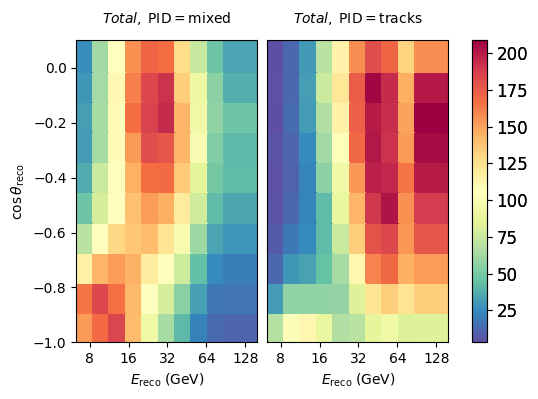

In [8]:
tmp_maps.plot()

In [9]:
template_maker.pipelines[0].stages[3].prop_height_range = 1
template_maker.pipelines[0].stages[3].setup()
tmp_maps_1km = template_maker.get_outputs(return_sum=True)[0]

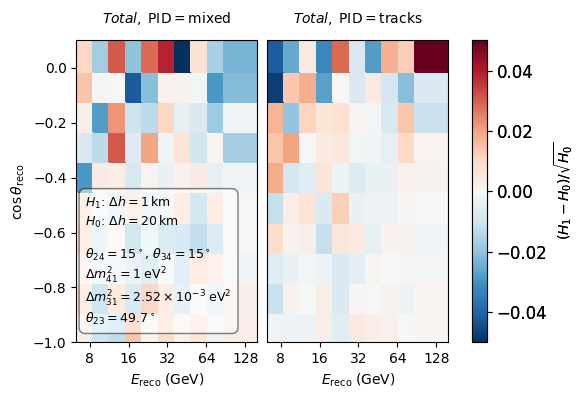

In [10]:
from copy import deepcopy
tmp_maps.set_errors(None)
tmp_maps_1km.set_errors(None)

params = deepcopy(template_maker.params)

fig = plt.figure()
ax = fig.add_subplot(111)

((tmp_maps_1km - tmp_maps) / np.sqrt(tmp_maps.nominal_values)).plot(
    vmin=-0.05, vmax=0.05,
    # vmin=-0.003, vmax=0.003,
    symm=True,
    # clabel=r"$(N_{\mathrm{nominal}} - N_{\mathrm{stp.+2\%}})/\sqrt{N_{\mathrm{nominal}}}$"
    clabel=r"$(H_1 - H_0)/\sqrt{H_0}$",
    # clabel=r"pull ($\sigma$)",
    ax=ax
)

# th24 = params.theta24.value.m_as('deg')
# th34 = params.theta34.value.m_as('deg')
th24 = 15
th34 = 15
dcp24 = params.deltacp24.value.m_as('deg')

plt.text(
    .05, .05,
    "\n".join([
        r"$H_1$: $\Delta h = 1\,\rm km$",
        r"$H_0$: $\Delta h = 20\,\rm km$",
        "",
        fr"$\theta_{{24}}={th24:.3g}^\circ$, $\theta_{{34}}={th34:.3g}^\circ$",
        r"$\Delta m^2_{41}=1\;\mathrm{eV^2}$",
        fr"$\Delta m^2_{{31}}={params.deltam31.m_as('eV^2') * 1e3:.3g}"
        r"\times10^{-3}\;\mathrm{eV^2}$",
        fr"$\theta_{{23}}={params.theta23.m_as('deg'):.3g}^\circ$"
    ]),
    fontsize=9,
    transform=ax.transAxes,
    verticalalignment='bottom',
    bbox={"facecolor": "white", "edgecolor": "k", "boxstyle": "round,pad=0.5", "alpha": 0.5}
)
plt.savefig("pull_prod_height_range_1km_vs_20_km_th24_15_deg_th34_15_deg_verification_sample.pdf")